# Transducing Language Models

In [1]:
%load_ext autoreload
%autoreload 2

In [89]:
from transduction import (
    FST, FSA, EPSILON, PrecoverDecomp, examples, Precover,
    LazyRecursive, BuggyLazyRecursive, EagerNonrecursive, LazyPrecoverNFA, LazyNonrecursive,
)
from transduction.vibes import visualize_automaton
from transduction.util import display_table

### Notes

Consider the following transducer:

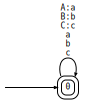

In [99]:
fst = examples.replace([('A', 'a'), ('a', 'a'), ('B', 'b'), ('b', 'b'), ('C', 'c'), ('c', 'c')])
fst

To compute the probability of a target string $\boldsymbol{y}$, we use the target string's preimage:
$$
f^{-1}(\boldsymbol{y}) = \mathrm{proj}_{\mathcal{X}}( \texttt{f} \circ \boldsymbol{y} )
$$

In [100]:
y = 'abc'

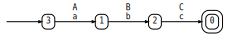

In [101]:
(fst @ FSA.from_string(y)).project(0).min()

The **precover** is defined similarly:
$$
\mathcal{P}(\boldsymbol{y}) = \mathrm{proj}_{\mathcal{X}}( \texttt{f} \circ \boldsymbol{y} \mathcal{Y}^*)
$$

These can each be computed using basic FST operations that are available in any good FST library.

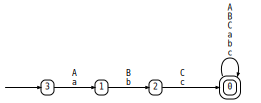

In [102]:
(fst @ (FSA.from_string(y) * FSA.universal(fst.B - {EPSILON}))).project(0).min()

Unfortunately, the precover is generally speaking an infinite set.  However, we have observed that many precovers can be factored into the following structure, which often allows us to represent certain precovers with only a finite number of strings.  And, most importantly, sum there probabilities.

$$\mathcal{P}(\boldsymbol{y}) = \mathcal{Q}(\boldsymbol{y}) \mathcal{X}^* \sqcup \mathcal{R}(\boldsymbol{y})$$

Note that neither $\mathcal{Q}(\boldsymbol{y})$ nor $\mathcal{R}(\boldsymbol{y})$ are guaranteed to be finite. We give algorithms for performing the factoring (with a certain sense of optimality) that represent each of $\mathcal{Q}(\boldsymbol{y})$ and $\mathcal{R}(\boldsymbol{y})$ as a DFA.  This ensures that the factorization algorithm terminates in finite time. 

In [103]:
P = Precover(fst, y)
Q, R = P.decomposition
P.show_decomposition()

In order to compute the prefix probabilities from this pair of DFAs, we need to enumerate the strings they contain, which is problematic in the case that they are infinite sets, so we resort to an approximate summing procedure that targets the highest-weight strings.

In [104]:
list(Q.language(np.inf))

['ABC', 'ABc', 'AbC', 'Abc', 'aBC', 'aBc', 'abC', 'abc']

In [105]:
list(R.min().language(np.inf))

[]

Precovers have the following properties.  

* For all functional transducers, $\mathcal{P}(\varepsilon) = \mathcal{X}^*$

* For all $\boldsymbol{y}, \boldsymbol{y}' \in \mathcal{Y}^*$
$$\mathcal{P}(\boldsymbol{y}) \supseteq \mathcal{P}(\boldsymbol{y} \, \boldsymbol{y}')$$


$$
\mathcal{P}(\boldsymbol{y} \, {\color{red}\boldsymbol{y}'}) = \{ \boldsymbol{x} \in \mathcal{P}(\boldsymbol{y}) \colon \underbrace{f(\boldsymbol{x}) \succeq  \boldsymbol{y}}_{\texttt{guaranteed}} \, {\color{red}\boldsymbol{y}'} \}
$$

In [106]:
p1 = Precover(fst, '')
p2 = Precover(fst, 'a')
p3 = Precover(fst, 'ab')
p4 = Precover(fst, 'abc')
assert p1.min >= p2.min >= p3.min >= p4.min

In [107]:
display_table([[p1, p2, p3, p4]], headings=['', 'a', 'ab', 'abc'])

Note each of the precovers in this sequence have common edges and arcs.  This is a general fact that the precover will start as a single state, universal machine (assuming a total function as we have generally assumed in the paper).  And, then as we refine the set by require it to cover extensions of the target string, we will see that we will change the accepting states and add arcs.  (This structure may not hold after DFA minimization.)  This leads to recursive algorithm for building and factoring the precover as we grow the target string, e.g., if we are sampling it symbol-by-symbol.

What does factoring look like?  How do we take a precover and factor it into a quotient and remainder.  Step one is determinization, as it will aggregate all information about any given run throught the precover DFA into a finite number of state whereas an NFA encoding of the precover would allow a source string's state to be disaggregated into may paths through the machine.  Now, that we have the deterministic machine, we need to identify which of its states general $\mathcal{X}*$, as those states correspond to strings that live in the quotient.  This identification is fairly trivial if we minimize the precover DFA as they are accepting states with a self-loop on every symbol in $\mathcal{X}$.  If the precover DFA is not minimized, then we can check if all states that are downstream (including itself) are both accepting and complete (i.e., have arcs of all symbols in $\mathcal{X}$).

Having identified the universal states in the precover DFA we derive the quotient DFA be removing all outgoing arcs from each of the universal states and make them accepting.  For the remainder DFA, we also remove all outgoing arcs for the universal states, then we define the accepting states to be accepting states in the precover DFA that are not also universal.  Each machine can be trimmed or minimized, if desired.

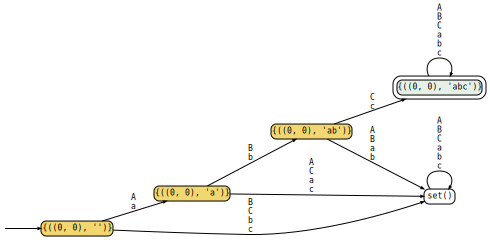

In [108]:
Precover(fst, y)

In [109]:
#from IPython.display import Latex, Markdown
#display(Latex(LazyPrecoverNFA.__doc__))

In [110]:
from transduction.eager_nonrecursive import is_universal
def graphviz(self):
    dfa = tmp.dfa.materialize()
    universal_states = {i for i in dfa.stop if is_universal(dfa, i, self.source_alphabet)}
    dead_states = dfa.states - dfa.trim().states
    def color_node(x):
        if x in universal_states: return '#E6F0E6'
        elif dfa.is_final(x): return '#f26fec'
        elif x in dead_states: return 'white'
        else: return '#f2d66f'
    return dfa.graphviz(fmt_node=set, sty_node=lambda x: {'style': 'filled,rounded', 'fillcolor': color_node(x)})

### A simple example

FST=


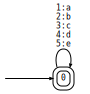

precover NFA=


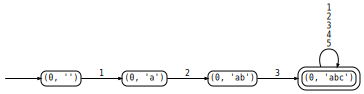

precover DFA=


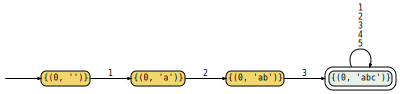

In [112]:
fst = examples.replace([('1', 'a'), ('2', 'b'), ('3', 'c'), ('4', 'd'), ('5', 'e')])
print('FST=')
display(fst)
tmp = LazyNonrecursive(fst)
assert tmp('abc') == ({'123'}, set())
print('precover NFA=')
display(tmp.nfa.materialize())
print('precover DFA=')
display(graphviz(tmp))

In [113]:
tmp = LazyRecursive(fst)
assert tmp('abc') == ({'123'}, set())

### Another simple example

This example shows how even a simple machine with a single state can lead to exponential summing in the length of the target string $\boldsymbol{y}$

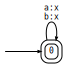

In [114]:
fst = examples.replace([('a', 'x'), ('b', 'x')])
fst

precover NFA=


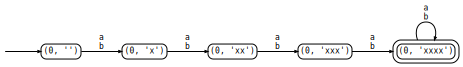

precover DFA=


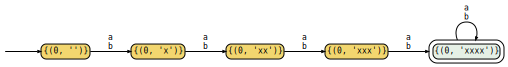

In [115]:
tmp = LazyNonrecursive(fst)
target = 'xxxx'
assert tmp(target) == ({
    'aaaa', 'aaab', 'aaba', 'aabb', 'abaa', 'abab', 'abba', 'abbb', 
    'baaa', 'baab', 'baba', 'babb', 'bbaa', 'bbab', 'bbba', 'bbbb'
}, set())
print('precover NFA=')
display(tmp.nfa.materialize().graphviz(fmt_node=lambda x: x))
print('precover DFA=')
display(graphviz(tmp))
Q,R = tmp.dfa_decomposition(target)
display_table([[Q.renumber(), R.renumber()]], headings=['quotient', 'remainder'])

### Newspeak

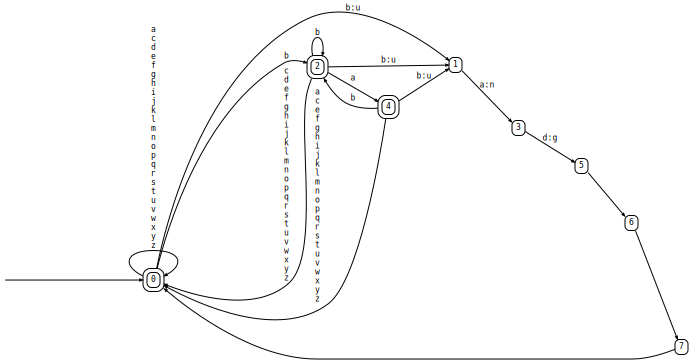

In [116]:
fst = examples.newspeak2()
fst

({'bar', 'baa', 'bam', 'bau', 'bae', 'bac', 'bal', 'baz', 'baj', 'ban', 'bab', 'baw', 'bah', 'bay', 'baq', 'bax', 'bai', 'bap', 'bak', 'bas', 'bao', 'baf', 'bat', 'bav', 'bag'}, {'ba'})
precover NFA=


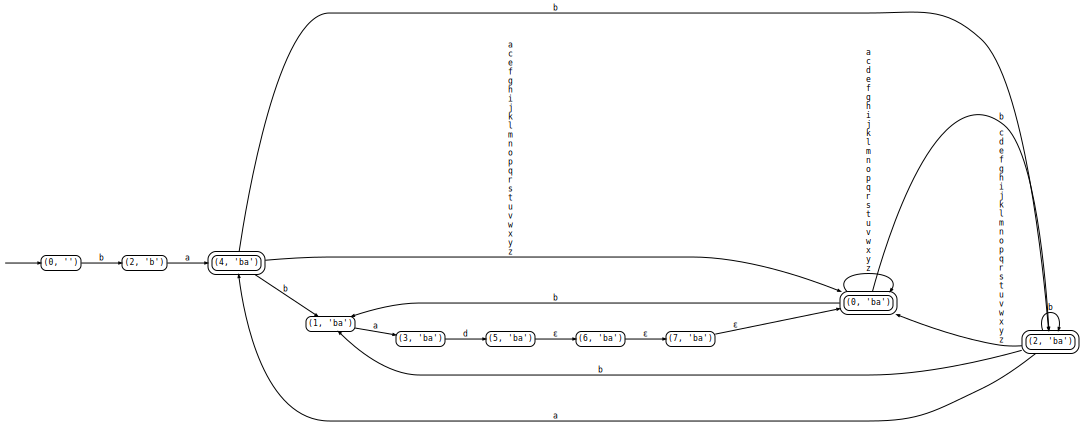

precover DFA=


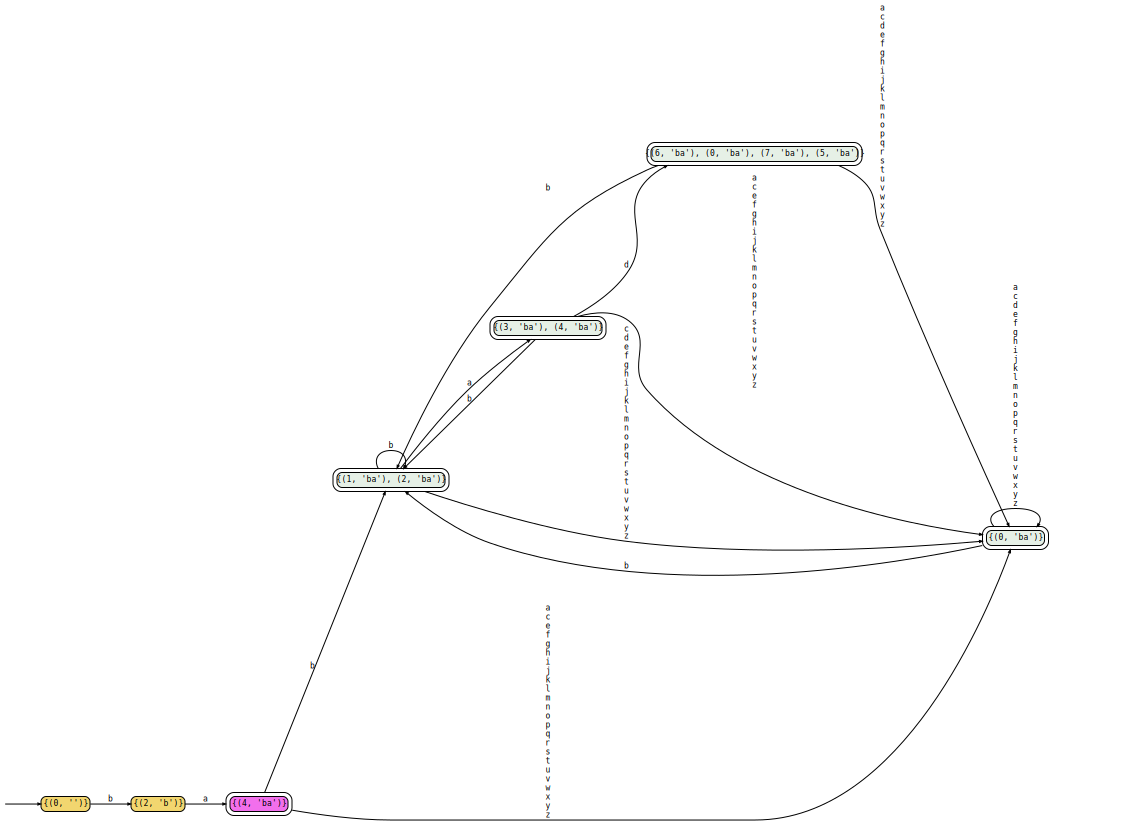

precover DFA minimal=


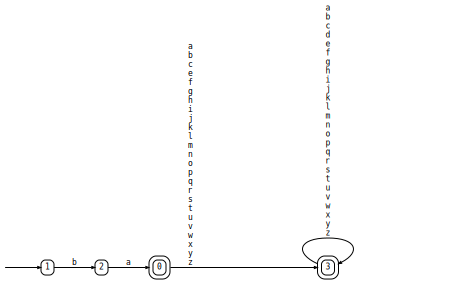

In [117]:
tmp = LazyNonrecursive(fst, max_steps=100)
target = 'ba'
output = tmp(target)
print(output)

print('precover NFA=')
display(tmp.nfa.materialize().graphviz())
print('precover DFA=')
display(graphviz(tmp))
print('precover DFA minimal=')
display(tmp.dfa.materialize().min().graphviz())

In [118]:
assert output == ({
    'baa', 'bag', 'bak', 'bay', 'baw', 'baq', 'bac', 'ban', 'bah', 
    'baz', 'bav', 'bal', 'bau', 'bap', 'bae', 'bar', 'bai', 'bam', 
    'bao', 'bab', 'baf', 'bat', 'baj', 'bax', 'bas'
}, {'ba'})

In [120]:
Q,R = tmp.dfa_decomposition(target)
display_table([[Q.renumber().graphviz(), R.renumber().graphviz()]], headings=['quotient', 'remainder'])

In [121]:
display_table([[
    Precover(fst, ''),
    Precover(fst, 'b'),
    Precover(fst, 'ba'),
    Precover(fst, 'bad'),
]], headings=['ε', 'b', 'ba', 'bad'])

ε,b,ba,bad


### Parity: an example of infinite remainder

FST=


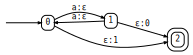

stopped early
(set(), {'aaaaaaaaaaa', 'aaaaa', 'aaaaaaaaaaaaaaaaaaa', 'aaaaaaaaa', 'a', 'aaaaaaaaaaaaaaaaa', 'aaa', 'aaaaaaaaaaaaa', 'aaaaaaa', 'aaaaaaaaaaaaaaa'})
precover NFA=


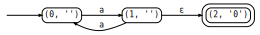

precover DFA=


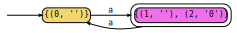

quotient,remainder
∅,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 1 <!-- start->0 --> start->0 <!-- 1 --> 1 0 <!-- 0->1 --> 0->1 a <!-- 1->0 --> 1->0 a"


In [124]:
fst = examples.parity({'a'})

print('FST=')
display(fst)
tmp = LazyNonrecursive(fst, max_steps=20)
target = '0'
output = tmp(target)
print(output)
print('precover NFA=')
display(tmp.nfa.materialize())
print('precover DFA=')
display(graphviz(tmp))
Precover(fst, target).show_decomposition()

In [125]:
display_table([[
    Precover(fst, ''),
    Precover(fst, '0'),
    Precover(fst, '1'),
]], headings=['', '0', '1'])

In [126]:
Q, R = tmp.dfa_decomposition(target)
display_table([[Q, R]], headings=['quotient','remainder'])

quotient,remainder
∅,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 {(0, '')} <!-- start->0 --> start->0 <!-- 1 --> 1 {(1, ''),(2, '0')} <!-- 0->1 --> 0->1 a <!-- 1->0 --> 1->0 a"


### Out of Sync

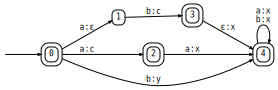

In [127]:
sam = examples.samuel_example()
sam

FST=


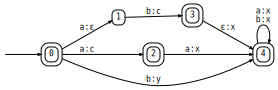

decomp: ({'a'}, set())
check decomposition:
├─ valid: ✔ equal to precover
├─ quotient:
├─ ✔ 'a' is a valid cylinder
└─ overall: ✔
precover NFA=


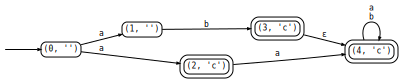

precover DFA=


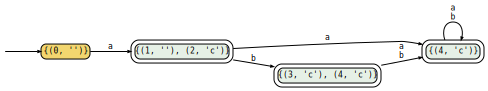

precover minimal DFA=


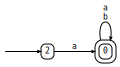

quotient,remainder
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 2 <!-- start->0 --> start->0 <!-- 1 --> 1 0 <!-- 0->1 --> 0->1 a",∅


In [129]:
fst = sam
target = 'c'
print('FST=')
display(fst)
tmp = LazyNonrecursive(fst)
have = tmp(target)
print('decomp:', have)
Precover(fst, target).check_decomposition(*have)
assert have == ({'a'}, set())
print('precover NFA=')
display(tmp.nfa.materialize())
print('precover DFA=')
display(graphviz(tmp))
print('precover minimal DFA=')
display(tmp.dfa.materialize().min())
Precover(fst, target).show_decomposition()

In [130]:
foo = BuggyLazyRecursive(sam)
target = 'c'
decomp = foo(target)
assert decomp == ({'aa', 'ab'}, {'a'}), decomp   # suboptimal, but valid decomposition
Precover(sam, target).check_decomposition(*decomp)

check decomposition:
├─ valid: ✔ equal to precover
├─ quotient:
├─ ✔ 'ab' is a valid cylinder
├─ ✘ 'ab' is not minimal because its strict prefix 'a' is a cylinder of the precover
├─ ✔ 'aa' is a valid cylinder
├─ ✘ 'aa' is not minimal because its strict prefix 'a' is a cylinder of the precover
├─ remainder:
├─ ✘ 'a' in precover and not a cylinder
└─ overall: ✘


False

In [131]:
moo = foo._as_fsa(target)
display_table([[
    moo.graphviz(fmt_node=lambda x: foo.frontier(x),
                 sty_node=lambda x: {'style': 'filled,rounded', 
                                     'fillcolor': '#E6F0E6' if foo.continuity(x, target) else ('#F9E6E6' if foo.discontinuity(x, target) else 'white')}
                ), 
    moo.graphviz(fmt_node=lambda x: x or 'ε'), 
    moo.min().graphviz(lambda x: '')
]], headings=['states', 'strings', 'minimized'])

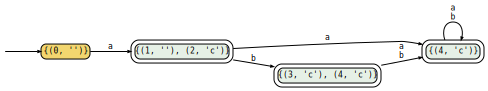

In [132]:
tmp = LazyNonrecursive(sam)
assert tmp(target) == ({'a'}, set())
graphviz(tmp)

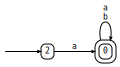

In [133]:
tmp.dfa.materialize().min()

In [134]:
Precover(sam, target).check_decomposition(*EagerNonrecursive(sam, max_steps=25)(target))

check decomposition:
├─ valid: ✔ equal to precover
├─ quotient:
├─ ✔ 'a' is a valid cylinder
└─ overall: ✔


True

In [136]:
Precover(sam, target).show_decomposition()

quotient,remainder
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 2 <!-- start->0 --> start->0 <!-- 1 --> 1 0 <!-- 0->1 --> 0->1 a",∅


In [137]:
Precover(sam, target).check_decomposition(*BuggyLazyRecursive(sam)(target))

check decomposition:
├─ valid: ✔ equal to precover
├─ quotient:
├─ ✔ 'ab' is a valid cylinder
├─ ✘ 'ab' is not minimal because its strict prefix 'a' is a cylinder of the precover
├─ ✔ 'aa' is a valid cylinder
├─ ✘ 'aa' is not minimal because its strict prefix 'a' is a cylinder of the precover
├─ remainder:
├─ ✘ 'a' in precover and not a cylinder
└─ overall: ✘


False

In [138]:
assert LazyRecursive(sam, max_steps=100)(target) == ({'a'}, set())

### Samuel's first PTB rule example

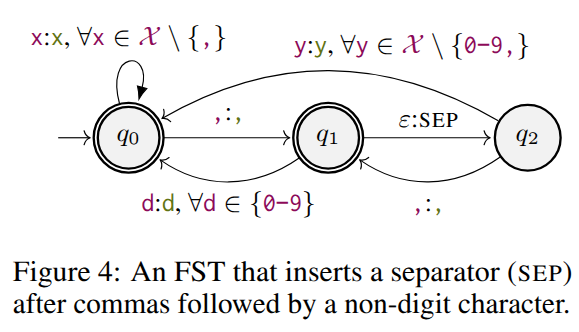

In [139]:
import string
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [140]:
#digits = {'0','1'}
#m = number_comma_separator(
#    digits | {','} | {'x', 'y', 'z'}, 
#    Digit = digits,
#)
digits = {str(i) for i in range(10)}
#m = number_comma_separator(digits | {','} | {'x', 'y', 'z'})
m = examples.number_comma_separator(set(string.printable) - set('\t\n\r\x0b\x0c'))
X = m.A
#m.graphviz(fmt_node=lambda x: x)

In [141]:
# def apply(m, x):
#     assert set(x) <= X
#     results = [''.join(y) for y in m(x, None).epsremove.trim.to_cfg().language(100).keys()]
#     assert len(results) == 1, results
#     return results[0]    

In [142]:
# assert apply(m, '') == ''
# assert apply(m, '1,1,,') == '1,1,|,'
# assert apply(m, '1') == '1'
# assert apply(m, ',,,') == ',|,|,'
# assert apply(m, '100,') == '100,'   
# assert apply(m, '100, ') == '100,| '
# assert apply(m, '3,50') == '3,50'
# assert apply(m, ',00,') == ',00,'
# assert apply(m, '123') == '123'
# assert apply(m, '1,2,3') == '1,2,3'
# assert apply(m, '1, 2, 3') == '1,| 2,| 3'
# assert apply(m, '1, 2, and 3') == '1,| 2,| and 3'

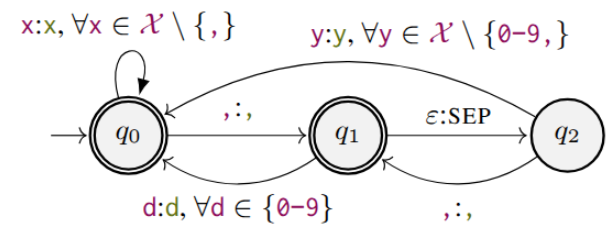

In [143]:
tmp = LazyNonrecursive(m)
assert tmp('1,| 2,| and 3') == ({'1, 2, and 3'}, set())

In [144]:
have = tmp('1,| 2,|')
want = ({'1, 2,' + x for x in tmp.source_alphabet if x not in '1234567890'}, set())
#print(have.quotient)
#print(want[0])
#print(have.quotient - want[0])
#print(want[0] - have.quotient)
assert have == want

In [145]:
target_prefix = '1,| 2,'
for y in tmp.target_alphabet:
    Q,R = tmp(target_prefix+y)
    assert len(R) == 0
    if y == '|' and target_prefix.endswith(','):
        assert len(Q) == len(tmp.source_alphabet) - len(digits), [target_prefix, y, Q]
    else:
        assert len(Q) <= 1, [target_prefix, y, Q]
    if len(Q) > 0:
        print(repr(y), Q)

'0' {'1, 2,0'}
'2' {'1, 2,2'}
'|' {'1, 2,k', '1, 2,Y', '1, 2,e', '1, 2,f', '1, 2,_', '1, 2,s', '1, 2,r', '1, 2,u', '1, 2,w', '1, 2,S', '1, 2,=', '1, 2,.', '1, 2,X', '1, 2,~', '1, 2,v', '1, 2,h', "1, 2,'", '1, 2,]', '1, 2,,', '1, 2,G', '1, 2,Q', '1, 2,j', '1, 2,H', '1, 2,^', '1, 2,n', '1, 2,T', '1, 2,m', '1, 2,y', '1, 2,\\', '1, 2,`', '1, 2,N', '1, 2,"', '1, 2,[', '1, 2,D', '1, 2,)', '1, 2,}', '1, 2,O', '1, 2,K', '1, 2,x', '1, 2,{', '1, 2,/', '1, 2,M', '1, 2,;', '1, 2,a', '1, 2,I', '1, 2,+', '1, 2,-', '1, 2,F', '1, 2,$', '1, 2,#', '1, 2,U', '1, 2,t', '1, 2,A', '1, 2,Z', '1, 2,R', '1, 2,|', '1, 2,q', '1, 2,&', '1, 2,B', '1, 2,:', '1, 2,%', '1, 2,@', '1, 2,b', '1, 2,p', '1, 2,o', '1, 2,<', '1, 2,i', '1, 2,?', '1, 2,*', '1, 2,P', '1, 2,(', '1, 2,W', '1, 2, ', '1, 2,d', '1, 2,c', '1, 2,g', '1, 2,l', '1, 2,E', '1, 2,!', '1, 2,L', '1, 2,>', '1, 2,V', '1, 2,J', '1, 2,C', '1, 2,z'}
'3' {'1, 2,3'}
'1' {'1, 2,1'}
'6' {'1, 2,6'}
'9' {'1, 2,9'}
'5' {'1, 2,5'}
'4' {'1, 2,4'}
'7' {'1, 2,7'}
'8' {'1, 

### Samuel's second PTB rule

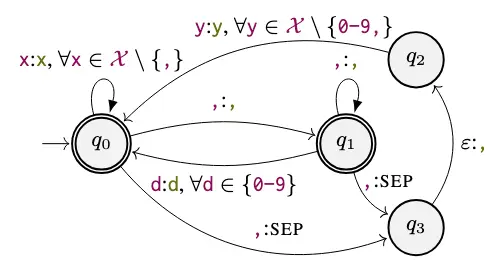!

```
Input: 'a,a ' -> Output: 'a_,a'
Input: 'a,1 ' -> Output: 'a,1'
Input: '1,1 ' -> Output: '1,1'
Input: '1,a ' -> Output: '1_,a'
```

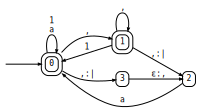

In [146]:
X = set('a,1')

SEP = '|'
Digits = set('1')

X = X | Digits | {','}

fst = FST()

# state 0
fst.add_I(0)
fst.add_F(0)
for x in X - {','}:
    fst.add_arc(0, x, x, 0)

fst.add_arc(0, ',', ',', 1)
fst.add_arc(0, ',', SEP, 3)

# state 1
fst.add_F(1)
fst.add_arc(1, ',', ',', 1)
fst.add_arc(1, ',', SEP, 2)
for d in Digits:
    fst.add_arc(1, d, d, 0)

# state 2
for y in X - Digits - {','}:
    fst.add_arc(2, y, y, 0)

# state 3
fst.add_arc(3, EPSILON, ',', 2)

fst.graphviz(fmt_node=lambda x: x)

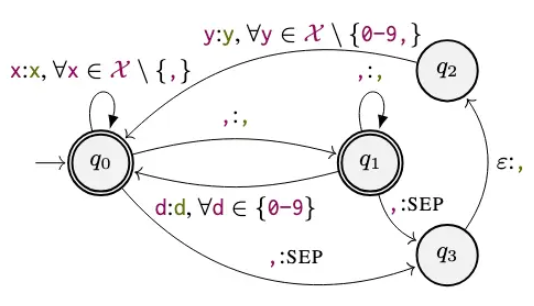

In [147]:
from transduction.fsa import FSA

In [148]:
fst('1,a', None).epsremoval().trim()

In [149]:
# Input: 'a,a ' -> Output: 'a_,a'
# Input: 'a,1 ' -> Output: 'a,1'
# Input: '1,1 ' -> Output: '1,1'
# Input: '1,a ' -> Output: '1_,a'

In [150]:
tmp = LazyNonrecursive(fst)
tmp('a,')

({'a,,', 'a,1'}, {'a,'})

In [151]:
tmp('1,')

({'1,,', '1,1'}, {'1,'})

In [152]:
tmp('1')

({'1'}, set())

In [153]:
tmp('a')

({'a'}, set())

In [154]:
tmp('1,|')

({'1,,a'}, set())

### Whitespace

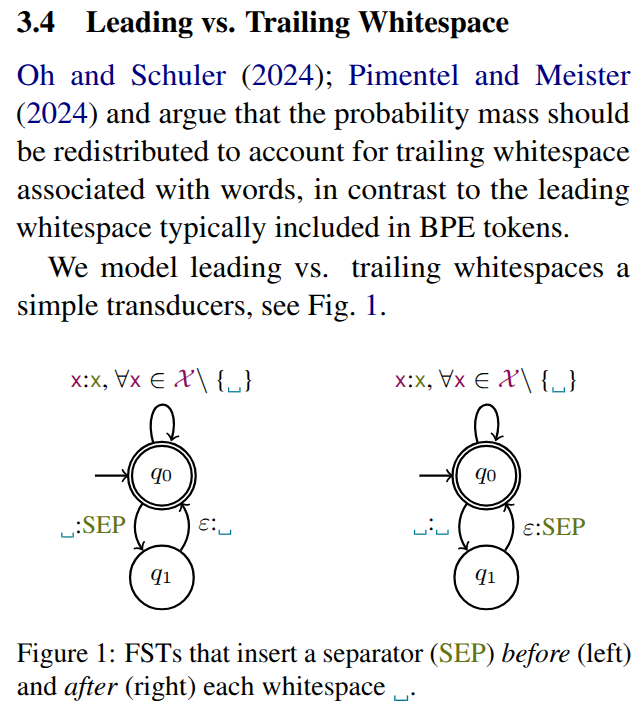

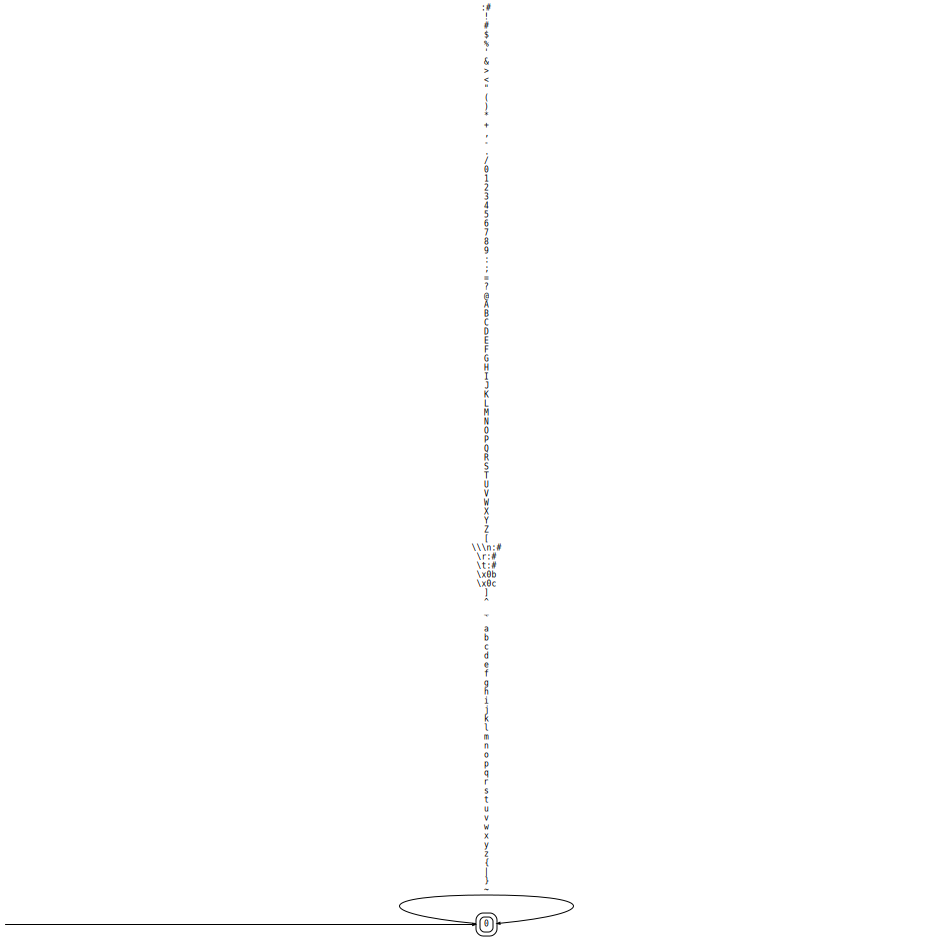

In [155]:
SEP = '#'
m = FST(start={0}, stop={0})
whitespace = {' ', '\t', '\n', '\r'}
for x in whitespace:
    m.add_arc(0, x, SEP, 0)
for x in set(string.printable) - whitespace: 
    m.add_arc(0, x, x, 0)
esc = lambda x: repr(x).replace('\\', '\\\\')[1:-1]
m.graphviz(fmt_edge=lambda i,a,j: f'{esc(a[0])}' if a[0] == a[1] else f'{esc(a[0])}:{esc(a[1])}')

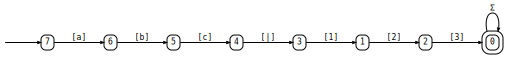

In [156]:
visualize_automaton(Precover(m, 'abc|123').min)

In [157]:
#Precover(m, 'abc|123').min.graphviz(fmt_edge=lambda i,a,j: f'{esc(a[0])}')

### Vibe-coded visualization tricks

In [158]:
fst = examples.number_comma_separator(set(string.printable) - set('\t\n\r\x0b\x0c'))
#fst

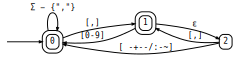

In [159]:
m = fst.project(0)
visualize_automaton(m)

### Other Test

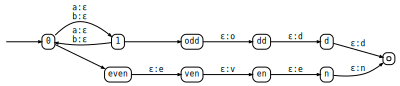

In [160]:
m = FST()

E, O, F = 0, 1, 2   # Even, Odd, Final
m.add_I(E)

# Toggle parity on every consumed input symbol; output is epsilon while reading
for x in {'a', 'b'}:
    m.add_arc(E, x, EPSILON, O)
    m.add_arc(O, x, EPSILON, E)

# Emit a single bit at the end via an epsilon-input arc, then accept
m.add_arc(E, EPSILON, EPSILON, 'even')   # even length → output 1
m.add_arc(O, EPSILON, EPSILON, 'odd')   # odd length  → output 0

m.add_arc('even', EPSILON, 'e', 'ven')
m.add_arc('ven', EPSILON, 'v', 'en')
m.add_arc('en', EPSILON, 'e', 'n')
m.add_arc('n', EPSILON, 'n', '')

m.add_arc('odd', EPSILON, 'o', 'dd')
m.add_arc('dd', EPSILON, 'd', 'd')
m.add_arc('d', EPSILON, 'd', '')

m.add_F('')

m

In [163]:
Precover(m, '').show_decomposition()

quotient,remainder
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 0 <!-- start->0 --> start->0",∅


In [164]:
from transduction.peekaboo import Peekaboo

tmp = Peekaboo(m, max_steps=50)
foo = tmp('even', return_strings=False)

display_table([[y, foo[y].quotient, foo[y].remainder] for y in foo], headings=['symbol', 'quotient', 'remainder'])

symbol,quotient,remainder
'e',∅,∅
'o',∅,∅
'n',∅,∅
'v',∅,∅
'd',∅,∅
